In [2]:
##### some basic modules
import os
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

##### Image-related modules
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
import cv2 

##### keras module
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model


In [1]:
##### Import custom function

from data_preprocessing import rgb_lab_transformation, feature_label_generation, data_generation
from visualization import visualize_validation_image
from WGANGP_model import RandomWeightedAverage, WGANGP

C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Uploading and Preprocessing Dataset

##### Uploading

In [5]:
size_row = 128
size_col = 128

dir_name = 'directory' # name of directory where image data is located

In [6]:
train_image, test_image, train_label, test_label = data_generation(dir_name = dir_name,
                                                                   image_size = (size_row, size_col),
                                                                   single_character = 'melon-chan') 
                                                                   # for training only one character, need to specify the character name

1/1


In [7]:
train_feature = train_image.reshape(train_image.shape[0], size_row, size_col, 1) 
test_feature = test_image.reshape(test_image.shape[0], size_row, size_col, 1)

x_feature = np.concatenate([train_feature, test_feature])
x_label = np.concatenate([train_label, test_label])

## 2. Defining and Fitting the Model

##### Call class

In [8]:
latent_dim = 1000
wgan_gp = WGANGP(input_shape = (size_row, size_col), latent_dim = latent_dim)

------------------------------
Discriminator structure:
------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 33, 33, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 33, 16)        64        
_______________________________________________________

##### Build models

In [12]:
discriminator_model = wgan_gp.discriminator_model
generator_model = wgan_gp.generator_model
generator = wgan_gp.generator

In [11]:
epochs = 5000
save_interval = 250

##### Fitting

In [13]:
image_valid = plt.imread('directory') # insert name of directory where validation image is located
image_valid = cv2.resize(image_valid, (size_row, size_col))

img_gray = rgb2gray(image_valid).reshape(size_row, size_col, 1)
img_gray3 = np.concatenate([img_gray]*3, axis = 2) # concatenating three gray images so that it can have 3 channels
img_lab3 = rgb2lab(img_gray3) # convert concatenated image to lab

valid_input = img_lab3[:,:,0].reshape(1, size_row, size_col, 1)/128

In [14]:
batch_size = 32

In [15]:
# Adversarial ground truths
valid = -np.ones((batch_size, 1))
fake =  np.ones((batch_size, 1))
dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty

In [16]:
n_critic = 5

In [17]:
g_losses = []
d_losses = []
img_colorized = []

for epoch in range(epochs):

    for _ in range(n_critic):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch-size number of images
        idx = np.random.randint(0, x_feature.shape[0], batch_size)
        l_channel = x_feature[idx]
        ab_channel = x_label[idx] 
        img_lab = np.concatenate([l_channel, ab_channel], axis = 3)
        
        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))        
        
        # Train the discriminator
        d_loss = discriminator_model.train_on_batch([img_lab, noise, l_channel],
                                                    [valid, fake, dummy])

    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = generator_model.train_on_batch([noise, l_channel], valid)

    g_losses.append(g_loss)
    d_losses.append(d_loss[0])
    
    # If at save interval => save generated image samples
    if epoch % save_interval == 0:

        print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
        zero_noise = np.zeros(latent_dim).reshape(1,latent_dim)
        gen_imgs = generator.predict([zero_noise, valid_input])
        image_indiv_ab = gen_imgs[0,:,:,1:].reshape(size_row, size_col,2)
        image_indiv = np.concatenate([img_lab3[:,:,:1]/128, image_indiv_ab], axis = 2)

        img_colorized.append(lab2rgb(image_indiv.astype('float64')*128)) 

C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 57.477989] [G loss: 0.971714]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1106 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


250 [D loss: -5.711812] [G loss: 0.214170]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1748 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


500 [D loss: -2.862846] [G loss: -2.215704]
750 [D loss: -2.682413] [G loss: -0.184422]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 24 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


1000 [D loss: -4.639717] [G loss: -1.910017]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 3 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


1250 [D loss: -3.985813] [G loss: 0.584930]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 7 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


1500 [D loss: -3.240247] [G loss: 3.879111]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


1750 [D loss: -3.063083] [G loss: 2.800480]
2000 [D loss: -3.884355] [G loss: 1.266228]
2250 [D loss: -3.855144] [G loss: 2.898417]
2500 [D loss: -3.620892] [G loss: 2.036281]
2750 [D loss: -3.532487] [G loss: 3.379510]
3000 [D loss: -3.004377] [G loss: 1.825058]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 6 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


3250 [D loss: -3.857155] [G loss: 0.309707]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 8 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


3500 [D loss: -4.164036] [G loss: 1.861795]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 72 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


3750 [D loss: -3.232725] [G loss: 0.026007]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 11 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


4000 [D loss: -3.559346] [G loss: 0.634057]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 13 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


4250 [D loss: -3.894412] [G loss: -0.490927]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 27 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


4500 [D loss: -2.908333] [G loss: 0.973280]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 28 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


4750 [D loss: -3.514505] [G loss: -1.570821]


C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 10 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


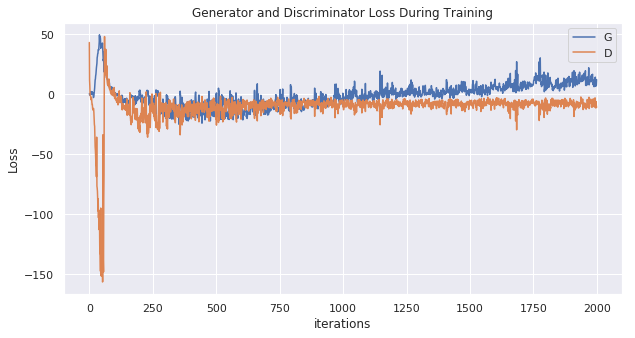

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

##### Visualizing

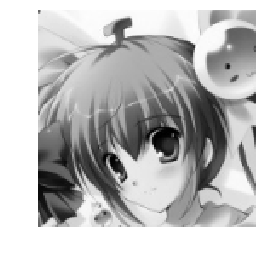

In [17]:
input_val = img_gray.copy()
plt.imshow(input_val.reshape(size_row, size_col), cmap = 'gray')
plt.axis('off')
plt.show()

In [19]:
grid_row = 4
grid_col = 5

In [20]:
g_row = []
i = 0

for r in range(grid_row):
    
    g_column = []
    
    for c in range(grid_col):
        g_column.append(img_colorized[i])
        i += 1
        
    g_column = np.concatenate(g_column, axis = 1)
    g_row.append(g_column)

g_row = np.concatenate(g_row)

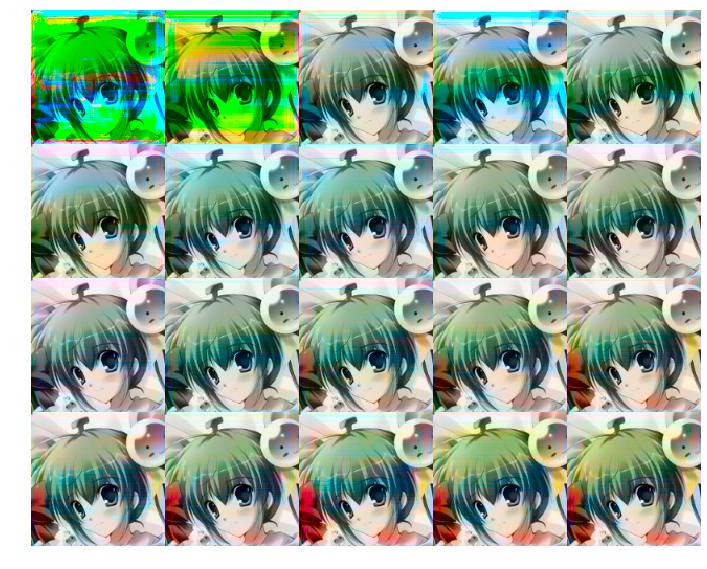

In [21]:
plt.figure(figsize = (12,12))
plt.axis('off')
plt.imshow(g_row)

##### Colorization using DIfferent Noise Values

In [22]:
def custom_noise(latent_dim = 1000, sequence_num = 5, interval = 1, interval_order = [-2,-1,0,1,2]):

    seq_length = int(latent_dim / sequence_num)

    noise_vec = []

    for s in range(sequence_num):

        for i in interval_order: # total length = sequence_num * len(interval_order)

            noise_original = np.zeros((1, latent_dim))
            noise_original[:, (s)*seq_length:(s+1)*seq_length] = noise_original[:, (s)*seq_length:(s+1)*seq_length] + interval*i

            noise_vec.append(noise_original)

    return np.concatenate(noise_vec, axis = 0)

In [23]:
gen_imgs = generator.predict([custom_noise(), np.concatenate([valid_input]*25, axis = 0)])

In [24]:
r, c = 5, 5

image_col = []
i = 0

for col_num in range(c):

    image_row = []

    for row_num in range(r):

        image_indiv_ab = gen_imgs[i,:,:,1:].reshape(size_row, size_col,2)
        image_indiv = np.concatenate([img_lab3[:,:,:1]/128, image_indiv_ab], axis = 2)
        image_row.append(image_indiv.astype('float64'))
        i += 1

    image_row = np.concatenate(image_row)
    image_col.append(image_row)

C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 201 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


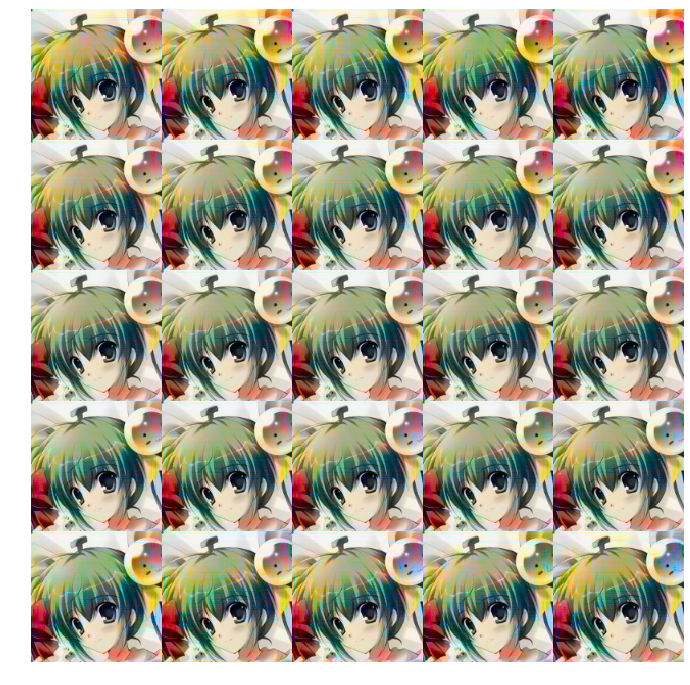

In [25]:
plt.figure(figsize = (12,12))
plt.axis('off')
plt.imshow(lab2rgb(np.concatenate(image_col, axis = 1)*128))
plt.show()

##### Test with different image (same character)

C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 9 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


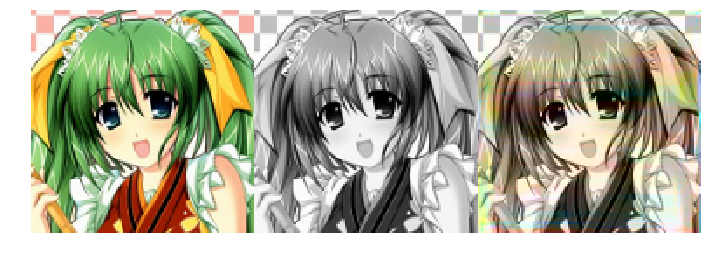

In [27]:
image_valid = plt.imread('directory') # insert name of directory where validation image is located
visualize_validation_image(image_valid, generator, image_size = (size_row, size_col), latent_dim = 1000)

##### Test with Different Character

C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


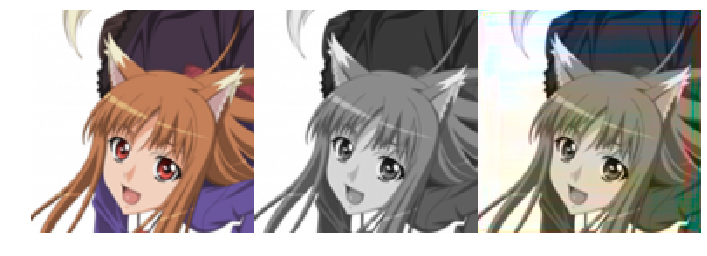

In [28]:
image_valid = plt.imread('directory') # insert name of directory where validation image is located
visualize_validation_image(image_valid, generator, image_size = (size_row, size_col), latent_dim = 1000)